# Problem 1: Classification

Importing libraries

In [36]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

1. Preprocesss the data table

In [ ]:
def read_latex_table(filename):
    # 1. Define clean headers manually 
    # (The LaTeX file has complex multi-line headers  that are hard to parse automatically)
    headers = [
        "ID", "Date", "Opponent", "Is_Night_Game", 
        "Location", "Is_Opponent_AP_Ranked", "Media", "Result"
    ]
    
    data_rows = []

    # 2. Open and process the file line by line
    with open(filename, 'r') as f:
        # Read the entire file content
        content = f.read()
        
        # Split content by the LaTeX row terminator `\\`
        # This handles cases where one row of data might span multiple lines in the text editor
        raw_rows = content.split(r'\\')
        
        for row in raw_rows:
            # Skip formattign lines (e.g., \hline, \begin{table})
            if "&" not in row or "textbf" in row:
                continue
            
            # 3. Clean the row data
            # Remove \hline if it's attached to the data
            clean_row = row.replace(r'\hline', '').strip()
            
            # Split by the LaTeX column delimiter `&`
            cols = [c.strip() for c in clean_row.split('&')]
            
            # Ensure we only keep rows that match our column count (data rows)
            if len(cols) == len(headers):
                data_rows.append(cols)

    # 4. Create DataFrame
    df = pd.DataFrame(data_rows, columns=headers)
    return df

df = read_latex_table('irishtable.tex')

# Display the dataframe
df.to_csv("Test.csv", index=False)

2. Convert Data table into np.array

In [20]:
# Define Features and Label
attributes = ["Is_Night_Game", "Location", "Is_Opponent_AP_Ranked", "Media"]
X = df[attributes]

# View Unique Columns
print("Unique values per column:")
for col in X.columns:
    print(f"{col}: {X[col].unique()}")

# Encode Categorical Features
enc = OneHotEncoder(sparse_output=False)
X_encoded = enc.fit_transform(X)

# Get number of features
num_features = X_encoded.shape[1]
feature_names = enc.get_feature_names_out(attributes)

print(f"\nNumber of features: {num_features}")
print(f"Feature names: {feature_names}")

Unique values per column:
Is_Night_Game: ['Yes' 'No']
Location: ['Away' 'Home' 'Neutral']
Is_Opponent_AP_Ranked: ['In' 'Out']
Media: ['1-ABC' '2-NBC' '3-XYZ']

Number of features: 10
Feature names: ['Is_Night_Game_No' 'Is_Night_Game_Yes' 'Location_Away' 'Location_Home'
 'Location_Neutral' 'Is_Opponent_AP_Ranked_In' 'Is_Opponent_AP_Ranked_Out'
 'Media_1-ABC' 'Media_2-NBC' 'Media_3-XYZ']


3. Baseline scores

There is a significant label imbalance:
- Training set: 19 Wins vs. 7 Losses
- Testing set: 13 Wins vs. 1 Loss

Therefore, we set Loss as the positive label

## 50% Random Guess

- TP = 1 loss x 0.5 = 0.5
- FN = 1 loss x 0.5 = 0.5
- TN = 13 wins x 0.5 = 6.5
- FP = 13 wins x 0.5 = 6.5

Scores:
- Accuracy = (0.5 + 6.5) / 14 = 50%
- Precision = 0.5 / 7 = 7%
- Recall = 0.5 / 1 = 50%
- F1 Score = (0.07 * 0.5) / (0.07 + 0.5) = 12.5%

## Weighted Probability

P(Predict Loss) = 7/26 = 0.27
P(Predict Win) = 19/26 = 0.73

- TP = 1 loss x 0.27 = 0.27
- FN = 1 loss x 0.73 = 0.73
- TN = 13 wins x 0.27 = 3.50
- FP = 13 wins x 0.73 = 9.50

Scores:
- Accuracy = (0.27 + 9.50) / 14 = 70%
- Precision = 0.27 / (0.27 + 3.50) = 7%
- Recall = 0.27 / 1 = 27%
- F1 Score = (0.071 * 0.27) / (0.071 + 0.27) = 11%

4. Calculate Correlations

In [22]:
# Create a DataFrame with the encoded features and the numeric label
df_encoded = pd.DataFrame(X_encoded, columns=feature_names)
df_encoded['Label'] = df['Result'].map({'L': 1, 'W': 0})

# Calculate Pearson correlation of all features against the 'Label' column
correlations = df_encoded.corr()['Label'].drop('Label')

# Sort by strength of correlation (absolute value)
sorted_correlations = correlations.abs().sort_values(ascending=False)

print("--- Correlations with Loss (Positive Label) ---")
print(correlations.sort_values(ascending=False))

print("\n--- Top Three Features (Absolute Strength) ---")
print(sorted_correlations.head(3))

--- Correlations with Loss (Positive Label) ---
Is_Night_Game_Yes            0.288278
Media_1-ABC                  0.218218
Is_Opponent_AP_Ranked_In     0.218218
Location_Away                0.186816
Media_2-NBC                  0.050252
Location_Home                0.025031
Is_Opponent_AP_Ranked_Out   -0.218218
Location_Neutral            -0.250000
Is_Night_Game_No            -0.288278
Media_3-XYZ                 -0.288675
Name: Label, dtype: float64

--- Top Three Features (Absolute Strength) ---
Media_3-XYZ          0.288675
Is_Night_Game_Yes    0.288278
Is_Night_Game_No     0.288278
Name: Label, dtype: float64


It can be seen that the least correlated feature is Media_2-NBC at an absolute value of 0.0503

 5. Build a Decision Tree Classifier

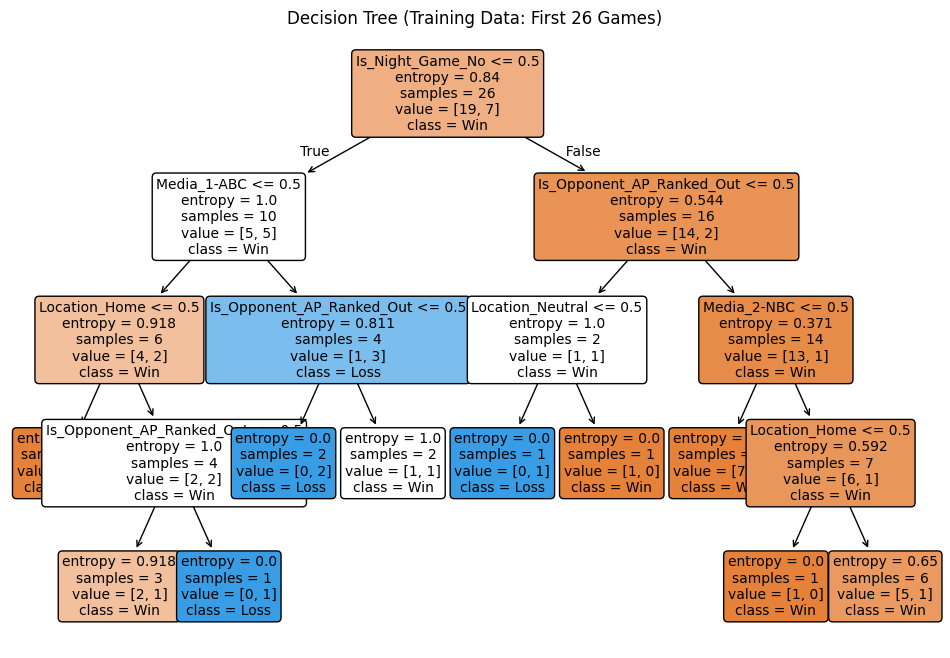

In [25]:
# Split Data into Training (First 26 rows) and Test
X_train = X_encoded[:26]
y_train = df_encoded['Label'][:26]

# 2. Build Decision Tree
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

# 3. Draw the tree
plt.figure(figsize=(12, 8))
plot_tree(clf, 
          feature_names=feature_names, 
          class_names=['Win', 'Loss'], # 0 is Win, 1 is Loss 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree (Training Data: First 26 Games)")
plt.show()

6. Use tree model to make predictions

In [27]:
# 1. Prepare Test Data (IDs 27-40, which correspond to indices 26 to 40)
X_test = X_encoded[26:40]
y_test_raw = df['Result'][26:40]

# Map labels: Loss=1 (Positive), Win=0 (Negative)
y_test = y_test_raw.map({'L': 1, 'W': 0}).astype(int)

# 2. Make Predictions
y_pred = clf.predict(X_test)

# 3. Calculate Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# 4. Report Results
print("--- Test Set Performance ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Detailed report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Win', 'Loss']))

--- Test Set Performance ---
Accuracy:  0.7857
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

Detailed Classification Report:
              precision    recall  f1-score   support

         Win       0.92      0.85      0.88        13
        Loss       0.00      0.00      0.00         1

    accuracy                           0.79        14
   macro avg       0.46      0.42      0.44        14
weighted avg       0.85      0.79      0.82        14



7. Build two new trees

--- Performance Comparison on Test Data ---
                       Accuracy  Precision  Recall  F1 Score
Model 2022 (ID 1-13)   0.714286        0.0     0.0       0.0
Model 2023 (ID 14-26)  0.857143        0.0     0.0       0.0
Model All (ID 1-26)    0.785714        0.0     0.0       0.0


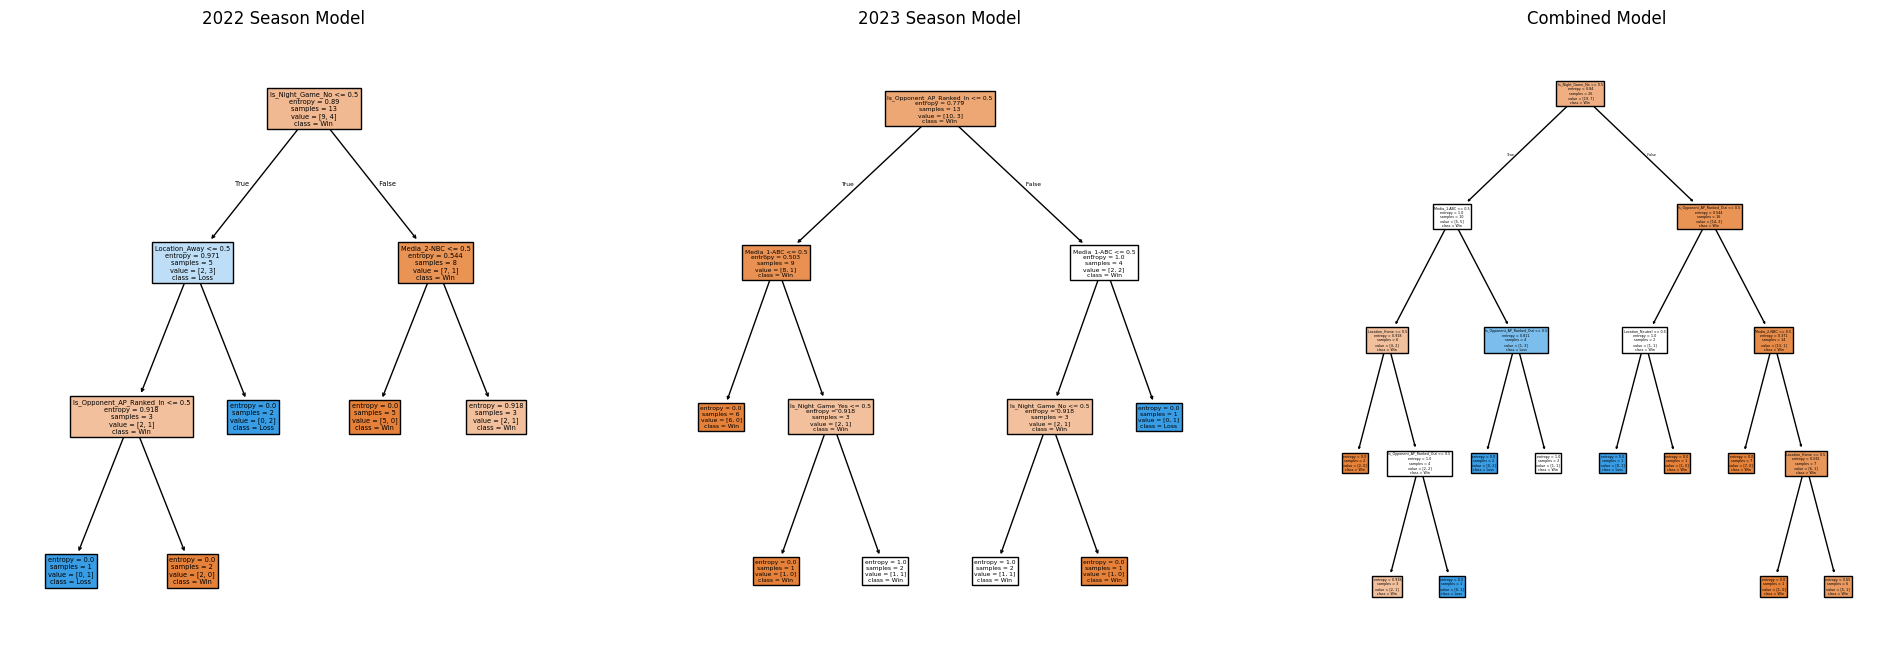

In [ ]:
# Prepare Labels (Loss=1, Win=0)
y_all = df_encoded['Label']

# 2022 Season: First 13 rows (Indices 0-13)
X_train_22 = X_encoded[0:13]
y_train_22 = y_all[0:13]

# 2023 Season: Next 13 rows (Indices 13-26)
X_train_23 = X_encoded[13:26]
y_train_23 = y_all[13:26]

# Test Data: Rows 27-40 (Indices 26-40)
X_test = X_encoded[26:40]
y_test = y_all[26:40]

# All Training: First 26 rows
X_train_all = X_encoded[0:26]
y_train_all = y_all[0:26]

# Train Models
clf_22 = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_22.fit(X_train_22, y_train_22)

clf_23 = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_23.fit(X_train_23, y_train_23)

clf_all = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_all.fit(X_train_all, y_train_all)

# Evaluation Function
def get_metrics(model, X, y):
    y_pred = model.predict(X)
    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1 Score': f1_score(y, y_pred, zero_division=0)
    }

# Compare Performance
metrics_22 = get_metrics(clf_22, X_test, y_test)
metrics_23 = get_metrics(clf_23, X_test, y_test)
metrics_all = get_metrics(clf_all, X_test, y_test)

results_df = pd.DataFrame([metrics_22, metrics_23, metrics_all], 
                          index=['Model 2022 (ID 1-13)', 'Model 2023 (ID 14-26)', 'Model All (ID 1-26)'])

print("--- Performance Comparison on Test Data ---")
print(results_df)

# Plot Trees for Comparison
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 2022 Model
plot_tree(clf_22, feature_names=feature_names, class_names=['Win', 'Loss'], filled=True, ax=axes[0])
axes[0].set_title("2022 Season Model")

# Plot 2023 Model
plot_tree(clf_23, feature_names=feature_names, class_names=['Win', 'Loss'], filled=True, ax=axes[1])
axes[1].set_title("2023 Season Model")

# Plot Original Model
plot_tree(clf_all, feature_names=feature_names, class_names=['Win', 'Loss'], filled=True, ax=axes[2])
axes[2].set_title("Combined Model")

plt.show()

8. Build a Naive Bayes Model

In [ ]:
# Initialize Gaussian Naive Bayes Model
gnb = GaussianNB()
gnb.fit(X_train_all, y_train_all)

# Make Predictions
y_pred_gnb = gnb.predict(X_test)

# Calculate Metrics
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb, zero_division=0)
recall_gnb = recall_score(y_test, y_pred_gnb, zero_division=0)
f1_gnb = f1_score(y_test, y_pred_gnb, zero_division=0)

# Report Results
print("--- Gaussian Naive Bayes Performance ---")
print(f"Accuracy:  {accuracy_gnb:.4f}")
print(f"Precision: {precision_gnb:.4f}")
print(f"Recall:    {recall_gnb:.4f}")
print(f"F1 Score:  {f1_gnb:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_gnb, target_names=['Win', 'Loss']))

--- Gaussian Naive Bayes Performance ---
Accuracy:  0.5714
Precision: 0.1429
Recall:    1.0000
F1 Score:  0.2500

Detailed Classification Report:
              precision    recall  f1-score   support

         Win       1.00      0.54      0.70        13
        Loss       0.14      1.00      0.25         1

    accuracy                           0.57        14
   macro avg       0.57      0.77      0.47        14
weighted avg       0.94      0.57      0.67        14



9. Creating 3 models with Random Forest, AdaBoost, and SVM

In [38]:
# Initialize Models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Train Models
rf.fit(X_train_all, y_train_all)
ada.fit(X_train_all, y_train_all)
svm.fit(X_train_all, y_train_all)

# Make Predictions
y_pred_rf = rf.predict(X_test)
y_pred_ada = ada.predict(X_test)
y_pred_svm = svm.predict(X_test)

# Helper function to calculate metrics
def evaluate_performance(name, y_test, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0)
    }

# Collect results
results = []
results.append(evaluate_performance("Random Forest", y_test, y_pred_rf))
results.append(evaluate_performance("AdaBoost", y_test, y_pred_ada))
results.append(evaluate_performance("SVM", y_test, y_pred_svm))

# Display as DataFrame
results_df = pd.DataFrame(results)
print(results_df)

           Model  Accuracy  Precision  Recall  F1 Score
0  Random Forest  0.785714        0.0     0.0       0.0
1       AdaBoost  0.714286        0.0     0.0       0.0
2            SVM  0.857143        0.0     0.0       0.0


10. Evaluate Classifiers

It is difficult to evaluate the models because there is only 1 loss (positive label) in the dataset. If you misclassify this one point, the F1-score is 0. Because of this, Naive Bayes was the only model to give a positive F1-score. Therefore, based on F1-score, Naive Bayes is the best. However, it had by far the worst accuracy at 57.14%.

However, if we judge these models on their accuracy only, SVM and the decision tree trained on only 2023 are the best at around 86%. Random Forest is quite good as well at 78.57%. However, I was surprised to see AdaBoost as one of the worst at only 71%.